<a id='top'></a>

### Assignment: Spam Detection

- <a href='#preprocessingbagofwords'>Preprocessing for Bag Of Words</a>

- <a href='#featureengineering'>Feature Engineering</a>

- <a href='#dectreevsrforest'>Decision Tree vs Random Forest</a>

- <a href='#preprocessingtfidf'>Preprocessing for Tfidf</a>

- <a href='#classimbalance'>Class Imbalance</a>

- <a href='#smote'>SMOTE</a>

- <a href='#optimization'>Optimization</a>

- <a href='#references'>References</a>

In [1]:
import pandas as pd

In [2]:
# Read the dataset as per the format
# response label <tab> sms as string
smsData = pd.read_table('smsdata.txt', sep = "\t", header = None)
smsData.head()

,0,1
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Fix the headers / column labels
smsData.columns = ["label", "text"]
smsData.head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Basic information about the data
smsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Peak at some of the `spam` and `good` sms

In [5]:
condition = smsData['label'] == 'spam'
smsData[condition].head()

,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [6]:
smsData[~condition].head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."
6,good,Even my brother is not like to speak with me. ...


<a id='preprocessingbagofwords'></a>
### Preprocessing for Bag Of Words

- Clean data by removing punctuation, stopwords, and reducing words to root form with lemmatization and stemming
- Feature engineer `num_digits`, `num_words`, `num_letters` for later
- Apply `CountVectorizer()` to count number of occurences of word in each sms
- result is now a sparse array with `rows == samples`, `columns = word or phrase up to 5 words long`

According to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for `CountVectorizer()`,

`CountVectorizer`: Convert a collection of text documents to a matrix of token counts

<a href='#top'>Back to top</a>

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re

def preprocess(text):
    # get digits
    digits = re.sub(r'[^\d]', '', text, re.I|re.A)
    # lower case and remove special characters\whitespaces
    # re.I ignore cases, re.A ASCII onl matching
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    tokenizer = nltk.WordPunctTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    stop_words = nltk.corpus.stopwords.words('english')

    tokens = tokenizer.tokenize(text)
    # filter stopwords out of text
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create text from filtered tokens
    text = ' '.join(filtered_tokens)
    # reduce each word to root form
    # for example, running and ran becomes run
    lemmatized_text = lemmatizer.lemmatize(text, pos = 'v')
    stemmed_text = stemmer.stem(lemmatized_text)
    # 3 extra features
    num_words = len(filtered_tokens)
    num_letters = len(text)
    num_digits = len(digits)
    
    return stemmed_text, num_words, num_letters, num_digits

In [8]:
import numpy as np
# vectorize allows for vector input into function
v_preprocess = np.vectorize(preprocess)

cleanData, num_words, num_letters, num_digits = v_preprocess(smsData['text'])

# apply CountVectorizer, counting each word and phrase up to 5 words long
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

<a id='featureengineering'></a>
### Feature Engineering

Here `num_words`, `num_letters`, `num_digits` and `num_pound` are compared with `label` to see if they should be used as features

<a href='#top'>Back to top</a>

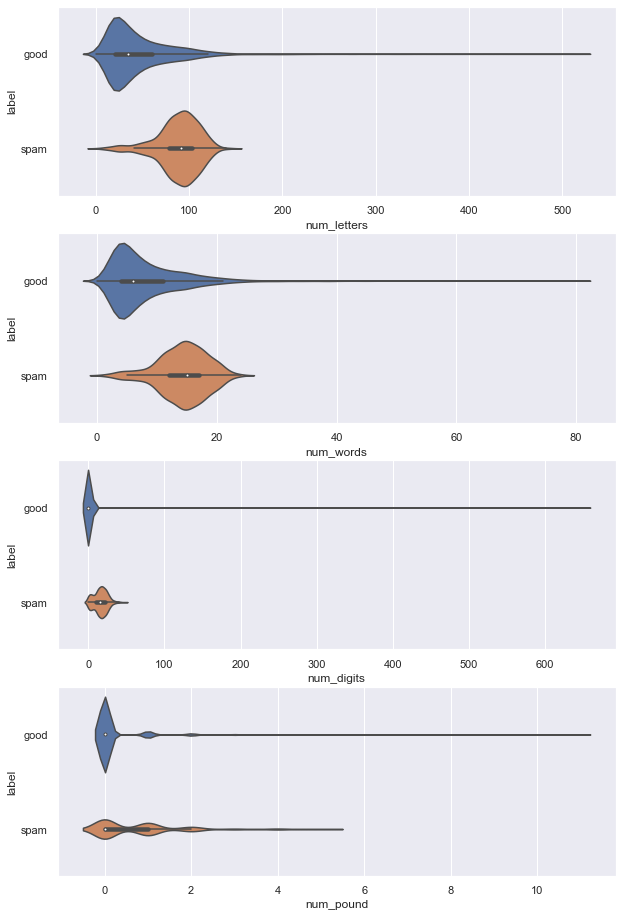

In [9]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

smsData['num_words'] = num_words
smsData['num_letters'] = num_letters
smsData['num_digits'] = num_digits
smsData['num_pound'] = smsData['text'].apply(lambda x: len([x for y in str(x) if y=='!']))
byLetters = smsData.sort_values(by = 'num_letters', ascending = False)
byWords = smsData.sort_values(by = 'num_letters', ascending = False)
byDigits = smsData.sort_values(by = 'num_digits', ascending = False)
byPound = smsData.sort_values(by = 'num_pound', ascending = False)

f, axes = plt.subplots(4, 1, figsize = (10, 16))

sb.violinplot(x = 'num_letters', y = 'label', data = byLetters, ax = axes[0])
sb.violinplot(x = 'num_words', y = 'label', data = byWords, ax = axes[1])
sb.violinplot(x = 'num_digits', y = 'label', data = byDigits, ax = axes[2])
sb.violinplot(x = 'num_pound', y = 'label', data = byPound, ax = axes[3])

Above shows higher `num_letters` and `num_words` seem to indicate `spam` sms

In [10]:
# peak at current features
features = pd.DataFrame(cv_matrix, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features['num_digits'] = num_digits
features['num_pound'] = smsData['num_pound']
features.head()

,aa,aa exhaust,aa exhaust hang,aah,aah bless,aah bless hows,aah bless hows arm,aah cuddle,aah cuddle would,aah cuddle would lush,...,zs subscription pw,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch,zyada kisi ko kuch nahi,num_words,num_letters,num_digits,num_pound
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16,82,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,23,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,107,25,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,35,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,43,0,0


As seen above, there are way too many features as there is a feature for every word, and phrases up to 5 words long. 

Attempt to reduce words by:

- Ranking words based on `mean` occurence per sms
- Take top `N` most frequently occurring words say `N = 40`

This is to remove possible typing errors like `juronh` instead of `jurong` and words that rarely occur as they are likely to not have an effect on `spam` and `good` messages.

In [11]:
frequentFeatures = pd.DataFrame({'mean_frequency': features.mean(axis = 0)}, index = features.columns)
frequentFeatures = frequentFeatures.sort_values(by='mean_frequency', ascending=False)
frequentFeatures.head()

,mean_frequency
num_letters,51.156676
num_words,8.935930
num_digits,3.649318
num_pound,0.250718
call,0.090093


<a id='dectreevsrforest'></a>
### DecisionTree vs RandomForest

Here `DecisionTreeClassifier` will be compared to `RandomForestClassifier` based mainly on `PPV` and `NPV` to determine better model.

<a href='#top'>Back to top</a>

In [12]:
results = {'accuracy': [],
           'ravel': [],
           'PPV': [],
           'NPV': [],
           'auroc': [],
           'title': []}

In [13]:
# take top 40 most frequent words
features = features[frequentFeatures.index[:40]]
features.head()

,num_letters,num_words,num_digits,num_pound,call,im,get,ur,dont,go,...,stop,back,sorry,see,still,today,mobile,think,new,hi
0,82,16,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,23,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,107,20,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,35,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,43,8,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
from scipy.sparse import csr_matrix
# convert to sparse matrix for efficient model trainig
features = csr_matrix(features.values)
response = smsData['label']

Establish which model is better

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve

def run_model(features, response, model, results, title):
    X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.25, 
                                                        random_state = 1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    results = analyze(y_test, y_test_pred, X_test, model, results, title)
    summary = summarize(results)
    results['summary'] = summary
    return results

def analyze(y_true, y_pred, X_test, model, results, title):
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18}, 
               xticklabels = ['good', 'spam'], yticklabels = ['good', 'spam'])
    fix_heatmap(title)
    
    tn, fp, fn, tp = cm.ravel()
    ppv = np.round(tp / (tp + fp), 3)
    npv = np.round(tn / (tn + fn), 3)
    
    results['accuracy'].append(np.round(accuracy_score(y_true, y_pred), 3))
    results['ravel'].append(cm.ravel())
    results['PPV'].append(ppv)
    results['NPV'].append(npv)

    results['title'].append(title)
    
    area_under_curve = visualize_auroc(y_true, X_test, model, title)
    results['auroc'].append(area_under_curve)
    
    return results

def visualize_auroc(y_true, X_test, model, title):
    fpr, tpr, thr = roc_curve(y_true, model.predict_proba(X_test)[:,1], pos_label = 'spam')
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {title}')
    auroc = auc(fpr, tpr)
    plt.legend(["AUROC {0:.2f}".format(auroc)])
    plt.show()
    return round(auroc, 3)

def fix_heatmap(title):
    bottom, top = plt.ylim()
    bottom += 0.5 
    top -= 0.5
    plt.ylim(bottom, top)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def summarize(results):
    return pd.DataFrame(list(zip(results['title'], results['accuracy'], results['ravel'],
                                 results['PPV'], results['NPV'], results['auroc'])),
                        columns = ['Titles', 'Classif Acc', 'TN, FP, FN, TP', 'PPV', 'NPV', 'AUROC'])

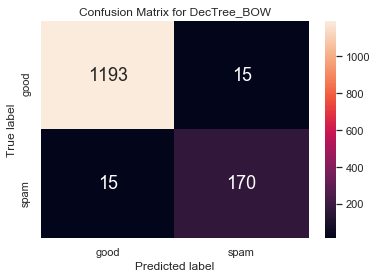

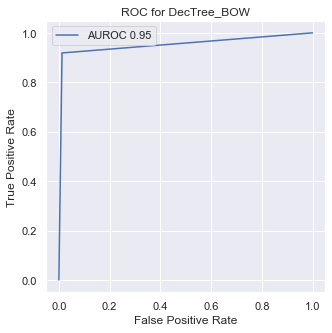

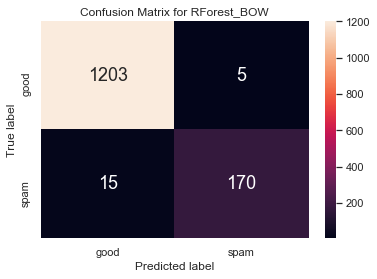

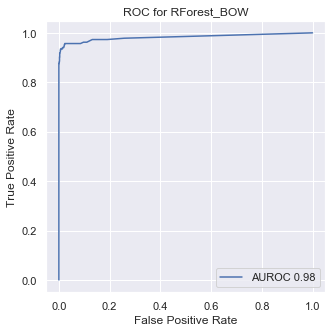

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUROC
0,DecTree_BOW,0.978,"[1193, 15, 15, 170]",0.919,0.988,0.953
1,RForest_BOW,0.986,"[1203, 5, 15, 170]",0.971,0.988,0.983


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

results = run_model(features, response, DecisionTreeClassifier(random_state = 1), 
                    results, 'DecTree_BOW')
results = run_model(features, response, RandomForestClassifier(random_state = 1), 
                    results, 'RForest_BOW')
results['summary']

`RandomForest` outperforms `DecisionTree` here based on `PPV`. This is now the baseline model to outperform.

Intuitively:
- `PPV == 1` represents zero `good` sms classified as `spam`
- `NPV == 1` represents zero `spam` sms classified as `good`
- `AUROC == 1` represents zero misclassifications

The aim should be to prioritize maximizing `PPV` over `NPV` although having both == 1 is ideal. In other words, considering email, it is important to have zero `good` emails going into the `spam` folder and having an occassional `spam` email in inbox is forgivable.

According to [here](https://www.jamesmaino.com/post/simple-intuitive-explanation-of-roc-and-auc-curves),
`AUC`: Rate of true positives and false positives for all threshold values of predicted labels and plot the results.

Description | Formula
--- | ---
sensitivity, recall, hit rate, or true positive rate (TPR) | TPR = $\frac{TP}{P}$ = $\frac{TP}{TP+FN}$ = 1-*FNR*
specificity, selectivity or true negative rate (TNR) | TNR = $\frac{TN}{N}$ = $\frac{TN}{TN+FP}$ = 1-*FPR*
precision or positive predictive value (PPV): | PPV = $\frac{TP}{TP+FP}$ = 1-*FDR*
negative predictive value (NPV): | NPV = $\frac{TN}{TN+FN}$ = 1-*FOR*
miss rate or false negative rate (FNR): | FNR = $\frac{TN}{P}$ = $\frac{FN}{FN+TP}$ = 1-*TPR*
fall-out or false positive rate (FPR): | FPR = $\frac{FP}{N}$ = $\frac{FP}{FP+TN}$ = 1-*TNR*
false discovery rate (FDR): | FDR = $\frac{FP}{FP+TP}$ = 1-*PPV*
false omission rate (FOR): | FOR = $\frac{FN}{FN+TN}$ = 1-*NPV*
Threat score (TS) or Critical Success Index (CSI): | TS = $\frac{TP}{TP+FN+FP}$

<a id='preprocessingtfidf'></a>
### Preprocessing for Tfidf

**Term-Frequency times Inverse-Document-Frequency (Tfidf).**

Instead of what was done previously, now:

- Get ratio of unique word to total words per sms (Term Frequency)
- Get ratio of total sms to sms with unique word in it (Inverse-Document-Frequency)
- Tfidf = TF * IDF
- Larger Tfidf means more importance

According to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html),

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

<a href='#top'>Back to top</a>

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

cleanData, _, _, _ = v_preprocess(smsData['text'])
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)

# get all unique words in the corpus
vocab = cv.get_feature_names()
tfidf_transformed = TfidfTransformer().fit_transform(cv_matrix)
tfidf_transformed = tfidf_transformed.toarray()

features = pd.DataFrame(tfidf_transformed, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features['num_digits'] = smsData['num_digits']
features['num_pound'] = smsData['num_pound']
features.head()

,aa,aa exhaust,aa exhaust hang,aah,aah bless,aah bless hows,aah bless hows arm,aah cuddle,aah cuddle would,aah cuddle would lush,...,zs subscription pw,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch,zyada kisi ko kuch nahi,num_words,num_letters,num_digits,num_pound
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16,82,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,23,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20,107,25,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9,35,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8,43,0,0


- Rank by `weight`
- Take top `N` most frequently occurring words say `N = 40`

In [18]:
%%time
frequentFeatures = pd.DataFrame({'weight': features.mean(axis = 0)}, index = features.columns)
frequentFeatures = frequentFeatures.sort_values(by='weight', ascending=False)
frequentFeatures.head()

Wall time: 34.9 s


,weight
num_letters,51.156676
num_words,8.935930
num_digits,3.649318
num_pound,0.250718
ok,0.010087


Test Tfidf against BOW model

In [19]:
# take top 40 most frequent words
features = features[frequentFeatures.index[:40]]
features.head()

,num_letters,num_words,num_digits,num_pound,ok,call,im,get,ill,ur,...,da,wat,text,dear,home,love,one,oh,need,think
0,82,16,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.076978,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,23,6,0,0,0.127041,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,107,20,25,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.056742,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,35,9,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,43,8,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.10439


In [20]:
# convert to sparse matrix for efficient model trainig
features = csr_matrix(features.values)

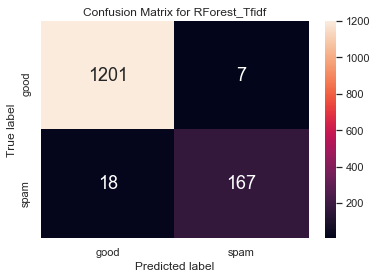

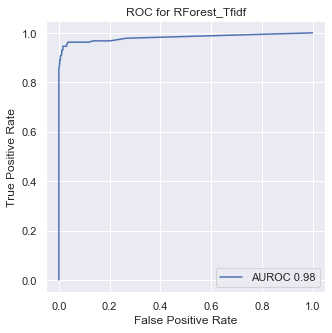

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUROC
0,DecTree_BOW,0.978,"[1193, 15, 15, 170]",0.919,0.988,0.953
1,RForest_BOW,0.986,"[1203, 5, 15, 170]",0.971,0.988,0.983
2,RForest_Tfidf,0.982,"[1201, 7, 18, 167]",0.960,0.985,0.982


In [21]:
results = run_model(features, response,
                    RandomForestClassifier(random_state = 1),
                    results, 'RForest_Tfidf')
results['summary']

`BOW` outperforms `Tfidf` in this case. Perhaps `Tfidf` will work better with larger datasets.

`BOW` will be used from now

<a id='classimbalance'></a>
### Class Imbalance

As seen way above, there is class imbalance. To rectify this, `class_weight` can be added to allow the model to place more emphasis on the under-represented class, `spam`.

- `balanced`: Places emphasis based on class imbalance in `response`
- 'balanced_subsample`: Does the same but for each subsample in each tree

According to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for `class_weight`,

- `balanced`: uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`

- `balanced_subsample`: is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

<a href='#top'>Back to top</a>

Same code as before to get `BOW`

In [22]:
cleanData, _, _, _ = v_preprocess(smsData['text'])
# apply CountVectorizer, counting each word and phrase up to 5 words long
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# peak at current features
features = pd.DataFrame(cv_matrix, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features['num_digits'] = smsData['num_digits']
features['num_pound'] = smsData['num_pound']

frequentFeatures = pd.DataFrame({'mean_frequency': features.mean(axis = 0)}, index = features.columns)
frequentFeatures = frequentFeatures.sort_values(by='mean_frequency', ascending=False)

# take top 40 most frequent words
features = features[frequentFeatures.index[:40]]

# convert to sparse matrix for efficient model trainig
features = csr_matrix(features.values)
features.shape

(5572, 40)

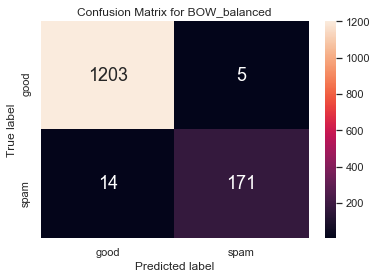

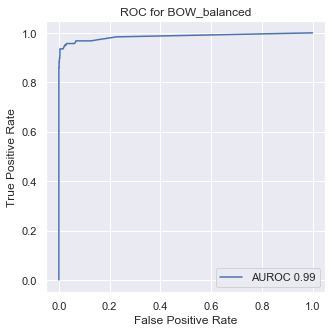

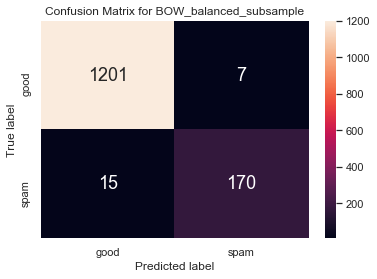

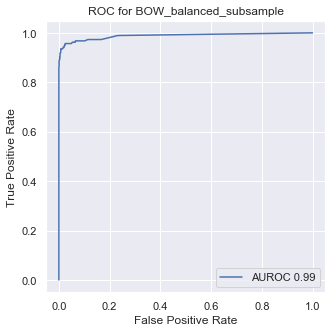

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUROC
0,DecTree_BOW,0.978,"[1193, 15, 15, 170]",0.919,0.988,0.953
1,RForest_BOW,0.986,"[1203, 5, 15, 170]",0.971,0.988,0.983
2,RForest_Tfidf,0.982,"[1201, 7, 18, 167]",0.960,0.985,0.982
3,BOW_balanced,0.986,"[1203, 5, 14, 171]",0.972,0.988,0.986
4,BOW_balanced_subsample,0.984,"[1201, 7, 15, 170]",0.960,0.988,0.988


In [23]:
results = run_model(features, response,
                    RandomForestClassifier(random_state = 1, class_weight = 'balanced'), 
                    results, 'BOW_balanced')
results = run_model(features, response,
                    RandomForestClassifier(random_state = 1, class_weight = 'balanced_subsample'), 
                    results, 'BOW_balanced_subsample')
results['summary']

`balanced` produces better `PPV` which is what we want

<a id='smote'></a>
### SMOTE

Instead of more emphasis on under-represented class, `SMOTE` allows for:

- Random generation of under-represented class until ratio `1:1`
- New samples will be similar but not neccessarily the same as existing samples

[More](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)
on Synthetic Minority Over-sampling Technique (SMOTE)

<a href='#top'>Back to top</a>

In [24]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_smote, y_smote = sm.fit_resample(features, response)

Using TensorFlow backend.


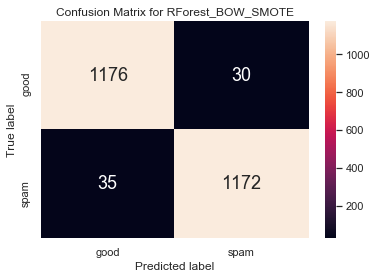

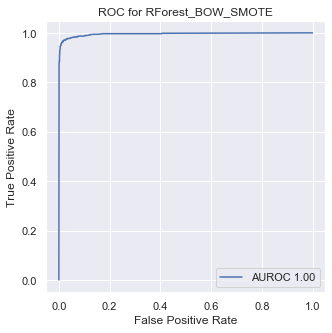

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUROC
0,DecTree_BOW,0.978,"[1193, 15, 15, 170]",0.919,0.988,0.953
1,RForest_BOW,0.986,"[1203, 5, 15, 170]",0.971,0.988,0.983
2,RForest_Tfidf,0.982,"[1201, 7, 18, 167]",0.960,0.985,0.982
3,BOW_balanced,0.986,"[1203, 5, 14, 171]",0.972,0.988,0.986
4,BOW_balanced_subsample,0.984,"[1201, 7, 15, 170]",0.960,0.988,0.988
5,RForest_BOW_SMOTE,0.973,"[1176, 30, 35, 1172]",0.975,0.971,0.995


In [25]:
results = run_model(X_smote, y_smote,
                    RandomForestClassifier(random_state = 1),
                    results, 'RForest_BOW_SMOTE')
results['summary']

`SMOTE` outperforms `class_weight` and will be used from now on

<a id='optimization'></a>
### Optimization

- Train best model so far with different hyperparameters to find best set
- Perform cross validation (cv) to see robustness of model

`cv = 5`: Split data into 5 equal parts, train on 4, test on 1. Repeat 4 more times so model is validated on each of the 5 equal parts in 5 separate models

<a href='#top'>Back to top</a>

In [26]:
# GridSearchCV requires response to be numerical
y_smote = y_smote.apply(lambda x: 1 if x == 'spam' else 0)
y_smote.value_counts()

1    4825
0    4825
Name: label, dtype: int64

In [27]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# try models with these parameters and choosing best
parameters = {'min_samples_leaf': range(1, 21, 5),
              'min_samples_split': range(2, 43, 10)}

model = RandomForestClassifier(random_state=1)
clf = RandomizedSearchCV(model, parameters, scoring='precision', cv = 5, n_iter = 10)
clf.fit(X_smote, y_smote)
clf.best_score_

Wall time: 34.3 s


0.9795900490001154

In [28]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [29]:
# change response back to words for analysis
y_smote = y_smote.apply(lambda x: 'spam' if x == 1 else 'good')
y_smote.value_counts()

good    4825
spam    4825
Name: label, dtype: int64

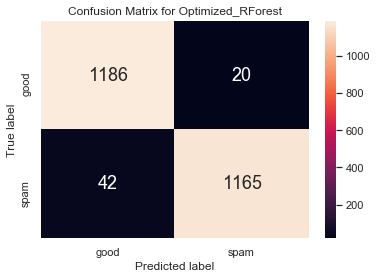

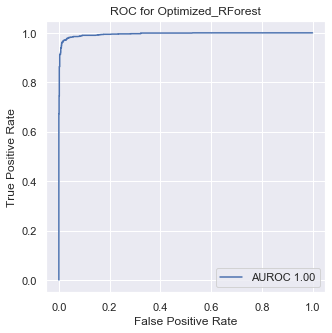

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUROC
0,DecTree_BOW,0.978,"[1193, 15, 15, 170]",0.919,0.988,0.953
1,RForest_BOW,0.986,"[1203, 5, 15, 170]",0.971,0.988,0.983
2,RForest_Tfidf,0.982,"[1201, 7, 18, 167]",0.960,0.985,0.982
3,BOW_balanced,0.986,"[1203, 5, 14, 171]",0.972,0.988,0.986
4,BOW_balanced_subsample,0.984,"[1201, 7, 15, 170]",0.960,0.988,0.988
5,RForest_BOW_SMOTE,0.973,"[1176, 30, 35, 1172]",0.975,0.971,0.995
6,Optimized_RForest,0.974,"[1186, 20, 42, 1165]",0.983,0.966,0.996


In [30]:
# looking at the optimized model
results = run_model(X_smote, y_smote, clf.best_estimator_,
                    results, 'Optimized_RForest')
results['summary']

`Optimized_RForest` gives best `PPV` and decent `NPV`. This means `1.7%` of `good` messages will be classified as spam and `1.34%` of `spam` will be classified as `good`.

<a id='references'></a>
### References

- https://www.kaggle.com/dejavu23/sms-spam-or-ham-beginner
- https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
- https://en.wikipedia.org/wiki/Precision_and_recall
- https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
- https://iyzico.engineering/how-to-calculate-tf-idf-term-frequency-inverse-document-frequency-from-the-beatles-biography-in-c4c3cd968296
- https://www.jamesmaino.com/post/simple-intuitive-explanation-of-roc-and-auc-curves

<a href='#top'>Back to top</a>